O nível de significância ideal para este teste é: 7.2%


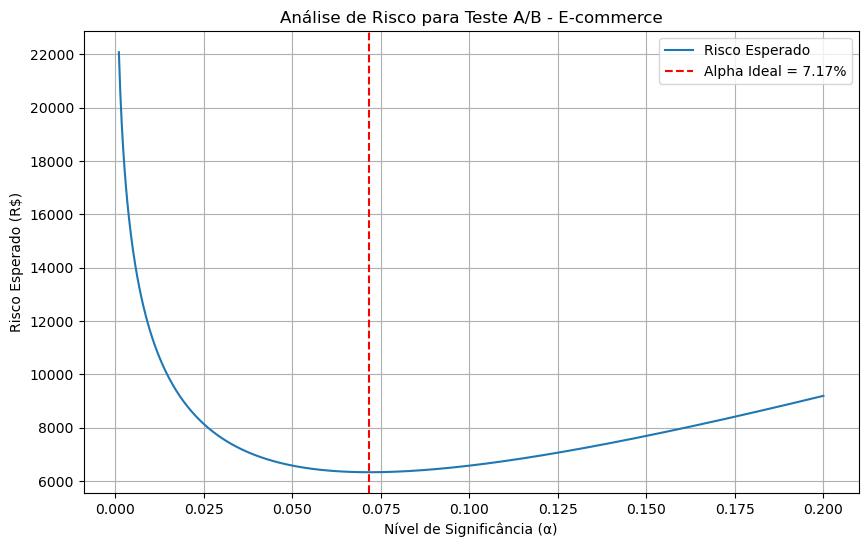

In [2]:
import numpy as np
from scipy.stats import norm

def calcular_alpha_otimo(probabilidade_efeito, custo_falso_positivo, custo_falso_negativo, funcao_poder):
    """
    Calcula o nível de significância ideal usando teoria da decisão
    
    Parâmetros:
        probabilidade_efeito: Chance da alteração ter efeito real (entre 0 e 1)
        custo_falso_positivo: Prejuízo se implementarmos uma mudança inútil
        custo_falso_negativo: Prejuízo se não implementarmos uma mudança boa
        funcao_poder: Função que calcula o poder do teste para um dado alpha
    
    Retorna:
        O valor de alpha que minimiza o prejuízo esperado
    """
    # Criamos uma lista de valores de alpha para testar
    valores_alpha = np.linspace(0.001, 0.5, 1000)
    riscos = []
    
    for alpha in valores_alpha:
        poder = funcao_poder(alpha)
        # Cálculo do risco esperado
        risco = (1 - probabilidade_efeito) * alpha * custo_falso_positivo + \
                probabilidade_efeito * (1 - poder) * custo_falso_negativo
        riscos.append(risco)
    
    # Retorna o alpha com menor risco
    return valores_alpha[np.argmin(riscos)]

# Função que calcula o poder do teste para um teste Z de duas amostras
def calcular_poder_testez(alpha, tamanho_efeito=0.2, tamanho_amostra=1000):
    """
    Calcula o poder estatístico para um teste Z bilateral
    
    Parâmetros:
        alpha: Nível de significância
        tamanho_efeito: Diferença padrão entre os grupos
        tamanho_amostra: Número de observações em cada grupo
    
    Retorna:
        Poder estatístico (1 - beta)
    """
    ponto_critico = norm.ppf(1 - alpha/2)  # Valor crítico do Z
    z_poder = tamanho_efeito * np.sqrt(tamanho_amostra)/2 - ponto_critico
    return norm.cdf(z_poder)

# Configurando os parâmetros do nosso caso de e-commerce
probabilidade_melhoria = 0.2  # 20% de chance da alteração ser realmente melhor
custo_implementar_inutil = 50000  # Custo de implementar uma feature que não funciona
custo_nao_implementar_boa = 200000  # Custo de perder oportunidade

# Calculando o alpha ideal
alpha_ideal = calcular_alpha_otimo(
    probabilidade_efeito=probabilidade_melhoria,
    custo_falso_positivo=custo_implementar_inutil,
    custo_falso_negativo=custo_nao_implementar_boa,
    funcao_poder=calcular_poder_testez
)

print(f"O nível de significância ideal para este teste é: {alpha_ideal:.1%}")

# Vamos visualizar a curva de risco
def visualizar_curva_risco(probabilidade_efeito, custo_fp, custo_fn, funcao_poder, titulo):
    alphas = np.linspace(0.001, 0.2, 1000)
    riscos = []
    
    for alpha in alphas:
        poder = funcao_poder(alpha)
        risco = (1 - probabilidade_efeito) * alpha * custo_fp + \
                probabilidade_efeito * (1 - poder) * custo_fn
        riscos.append(risco)
    
    alpha_otimo = alphas[np.argmin(riscos)]
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(alphas, riscos, label='Risco Esperado')
    plt.axvline(alpha_otimo, color='r', linestyle='--', 
                label=f'Alpha Ideal = {alpha_otimo:.2%}')
    plt.xlabel('Nível de Significância (α)')
    plt.ylabel('Risco Esperado (R$)')
    plt.title(titulo)
    plt.legend()
    plt.grid()
    plt.show()

visualizar_curva_risco(
    probabilidade_efeito=0.2,
    custo_fp=50000,
    custo_fn=200000,
    funcao_poder=calcular_poder_testez,
    titulo='Análise de Risco para Teste A/B - E-commerce'
)

In [3]:
# Gerando dados simulados para o teste A/B
np.random.seed(42)  # Para reproduzibilidade

# Grupo de controle - conversão de 10%
controle = np.random.binomial(1, 0.10, size=1000)

# Grupo de tratamento - conversão de 12% (efeito de 20% relativo)
tratamento = np.random.binomial(1, 0.12, size=1000)

# Função para realizar o teste Z
def teste_z_ab(controle, tratamento, alpha=0.05):
    p_controle = np.mean(controle)
    p_tratamento = np.mean(tratamento)
    
    n_controle = len(controle)
    n_tratamento = len(tratamento)
    
    # Calculando o erro padrão
    p_pool = (np.sum(controle) + np.sum(tratamento)) / (n_controle + n_tratamento)
    erro_padrao = np.sqrt(p_pool * (1 - p_pool) * (1/n_controle + 1/n_tratamento))
    
    # Estatística Z
    z_score = (p_tratamento - p_controle) / erro_padrao
    
    # Valor crítico
    z_critico = norm.ppf(1 - alpha/2)
    
    # Decisão
    rejeitar_h0 = abs(z_score) > z_critico
    p_valor = 2 * (1 - norm.cdf(abs(z_score)))
    
    return {
        'z_score': z_score,
        'p_valor': p_valor,
        'rejeitar_h0': rejeitar_h0,
        'diferenca': p_tratamento - p_controle,
        'alpha_usado': alpha
    }

# Executando com o alpha ideal que calculamos
resultado = teste_z_ab(controle, tratamento, alpha=alpha_ideal)

print("\nResultado do Teste A/B:")
print(f"Diferença observada: {resultado['diferenca']:.2%}")
print(f"P-valor calculado: {resultado['p_valor']:.4f}")
print(f"Nível de significância usado: {resultado['alpha_usado']:.2%}")
print(f"Decisão: {'Rejeitar H0 - Implementar feature' if resultado['rejeitar_h0'] else 'Não rejeitar H0 - Manter como está'}")


Resultado do Teste A/B:
Diferença observada: 1.20%
P-valor calculado: 0.3834
Nível de significância usado: 7.19%
Decisão: Não rejeitar H0 - Manter como está


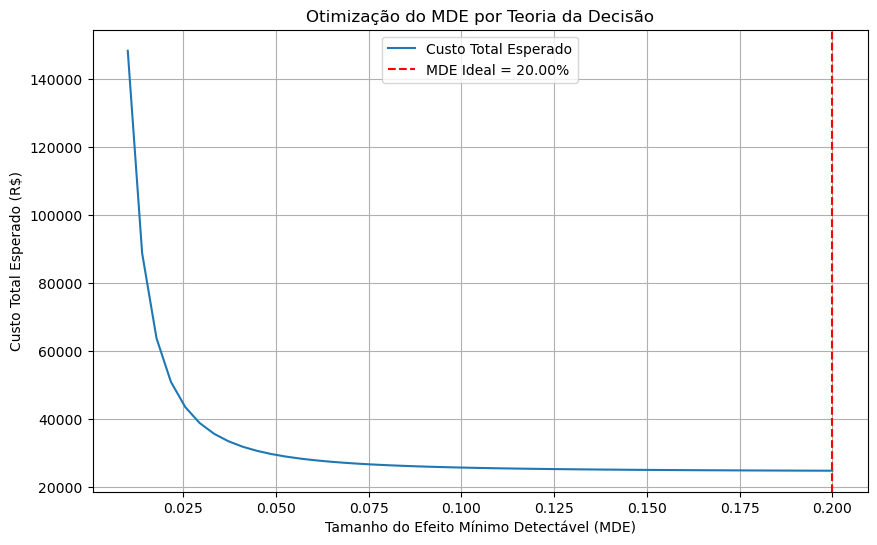


MDE ideal para este cenário: 20.00%


In [5]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def calcular_custo_total(efeito_minimo, custo_por_amostra, probabilidade_efeito, custo_falso_positivo, custo_falso_negativo, poder_desejado=0.8):
    """
    Calcula o custo total esperado para um dado MDE.
    
    Parâmetros:
        efeito_minimo: Tamanho do efeito mínimo a ser detectado (MDE)
        custo_por_amostra: Custo por observação no teste (R$)
        probabilidade_efeito: Chance de que o efeito real exista
        custo_falso_positivo: Custo de implementar uma mudança inútil
        custo_falso_negativo: Custo de não implementar uma mudança boa
        poder_desejado: Poder estatístico alvo (padrão: 80%)
    
    Retorna:
        Custo total esperado (R$)
    """
    # Tamanho de amostra necessário (fórmula para teste Z de proporções)
    n_por_grupo = 2 * ((norm.ppf(0.8) + norm.ppf(0.95)) ** 2 / (efeito_minimo ** 2))
    custo_amostragem = 2 * n_por_grupo * custo_por_amostra
    
    # Alpha ótimo baseado na Teoria da Decisão (usando código anterior)
    alpha = calcular_alpha_otimo(
        probabilidade_efeito,
        custo_falso_positivo,
        custo_falso_negativo,
        lambda a: calcular_poder_testez(a, efeito_minimo, n_por_grupo)
    )
    
    # Poder real com alpha ajustado
    poder_real = calcular_poder_testez(alpha, efeito_minimo, n_por_grupo)
    
    # Custo esperado de erros
    custo_erros = (1 - probabilidade_efeito) * alpha * custo_falso_positivo + \
                  probabilidade_efeito * (1 - poder_real) * custo_falso_negativo
    
    return custo_amostragem + custo_erros

# Exemplo: E-commerce com custo por usuário no teste
mde_testes = np.linspace(0.01, 0.2, 50)  # MDEs de 1% a 20%
custos = [calcular_custo_total(
    efeito_minimo=mde,
    custo_por_amostra=0.50,  # R$0.50 por usuário (incentivos, perda de vendas, etc.)
    probabilidade_efeito=0.3,
    custo_falso_positivo=50000,
    custo_falso_negativo=200000
) for mde in mde_testes]

# Encontrar o MDE ideal (menor custo total)
mde_ideal = mde_testes[np.argmin(custos)]

# Plotar resultados
plt.figure(figsize=(10, 6))
plt.plot(mde_testes, custos, label='Custo Total Esperado')
plt.axvline(mde_ideal, color='r', linestyle='--', 
            label=f'MDE Ideal = {mde_ideal:.2%}')
plt.xlabel('Tamanho do Efeito Mínimo Detectável (MDE)')
plt.ylabel('Custo Total Esperado (R$)')
plt.title('Otimização do MDE por Teoria da Decisão')
plt.legend()
plt.grid()
plt.show()

print(f"\nMDE ideal para este cenário: {mde_ideal:.2%}")

Definir os custos de **falso positivo** (Erro Tipo I) e **falso negativo** (Erro Tipo II) é a parte mais crítica e contextual da análise. Vou explicar com exemplos práticos e um passo a passo para estimar esses valores em diferentes cenários:

---

### **1. Custo de Falso Positivo (Erro Tipo I)**
*"Implementar uma mudança que não tem efeito real."*

#### **Como calcular:**
Some todos os custos associados a:
- **Custo direto de implementação** (ex.: desenvolvimento, treinamento)
- **Custo de oportunidade** (recursos alocados que poderiam ser usados em outras melhorias)
- **Impacto negativo potencial** (ex.: piora na experiência do usuário, reputação)

#### **Exemplo Prático: E-commerce**
| Componente de Custo          | Valor (R$) |
|------------------------------|-----------|
| Desenvolvimento da feature   | 20.000    |
| Campanha de marketing        | 10.000    |
| Manutenção mensal            | 5.000     |
| Custo de oportunidade (6 meses)| 15.000  |
| **Total**                    | **50.000**|

---

### **2. Custo de Falso Negativo (Erro Tipo II)**
*"Deixar de implementar uma mudança que teria efeito positivo."*

#### **Como calcular:**
Estime o **lucro perdido** durante o período até o próximo teste:
- Ganho incremental por unidade de tempo × Tempo até reavaliação
- Considere a **vida útil esperada** da mudança

#### **Exemplo: Teste A/B de Preço**
| Componente de Custo          | Cálculo                | Valor (R$) |
|------------------------------|------------------------|-----------|
| Lucro incremental por mês    | R$10.000               | 10.000    |
| Tempo até próximo teste      | 6 meses                |           |
| Prob. de não retestar        | 50% (perda permanente) |           |
| **Total**                    | (10k × 6) + (10k × 6 × 0.5)| **90.000**|

---

### **Método Passo a Passo para Estimativa**

#### **Passo 1: Mapeie as Consequências**
- Para **falso positivo**: Liste todas as despesas acionadas pela decisão de implementar.
- Para **falso negativo**: Projete o fluxo de caixa perdido.

#### **Passo 2: Ajuste por Probabilidades**
- Multiplique por:
  - Chance da decisão ser irreversível (ex.: 30%)
  - Fator de desconto temporal (valores futuros valem menos)

#### **Passo 3: Cenários Complexos (Ex.: Saúde)**
```python
# Exemplo: Teste de droga farmacêutica
custo_falso_positivo = {
    "ensaios_clinicos": 50e6,
    "regulatory": 20e6,
    "reputacao": 100e6  # Valor presente da perda de vendas futuras
}

custo_falso_negativo = {
    "vendas_perdidas": 200e6 * 0.3,  # 30% de chance de aprovação em outros países
    "vidas_salvas": 1e6  # Valor ético estimado
}
```

---

### **Planilha de Cálculo Automatizado (Python)**
```python
def calcular_custos_erros(cenario):
    if cenario == "ecommerce":
        fp = 50000  # Custo fixo + variável
        fn = 200000 * 0.7  # Ajustado por probabilidade
    elif cenario == "saude":
        fp = 170e6
        fn = 200e6 * 0.3 + 1e6
    else:
        raise ValueError("Cenário desconhecido")
    
    return {"falso_positivo": fp, "falso_negativo": fn}

# Uso:
custos = calcular_custos_erros("ecommerce")
print(f"Custo FP: R${custos['falso_positivo']:,.2f}")
print(f"Custo FN: R${custos['falso_negativo']:,.2f}")
```

---

### **Regras Práticas**
1. **Startups**: 
   - FN >> FP (custo de perder crescimento é crítico)
   - Ex.: FN = 5× o custo de FP

2. **Empresas Estáveis**: 
   - FP ≈ FN (otimização incremental)
   
3. **Setor Regulado** (ex.: saúde):
   - FP extremamente alto (risco de vidas)

---

### **Erros Comuns a Evitar**
1. **Ignorar custos indiretos** (ex.: desgaste da equipe)
2. **Não atualizar os valores** conforme novos dados
3. **Subestimar o custo de atraso** (especialmente em mercados competitivos)

Essa abordagem transforma uma decisão estatística abstrata em uma **avaliação financeira concreta**, alinhando testes A/B com os objetivos de negócio.

---

Definir a **probabilidade do efeito** (a probabilidade prévia de que sua mudança tenha um impacto real) é uma combinação de dados históricos, intuição informada e contexto do negócio. Vou explicar métodos práticos para estimar esse valor, com exemplos e código Python para ajudar na quantificação.

---

## **Métodos para Estimar a Probabilidade do Efeito**

### 1. **Baseado em Dados Históricos** *(Mais Objetivo)*  
Calcule a proporção de testes A/B que tiveram efeitos significativos no passado.

#### **Exemplo:**
- Empresa fez **50 testes A/B** nos últimos 2 anos.
- **15** deles tiveram efeitos positivos e estatisticamente significativos.
- Probabilidade do efeito = `15/50 = 30%`.

```python
testes_totais = 50
testes_efetivos = 15
prob_efeito = testes_efetivos / testes_totais
print(f"Probabilidade baseada em histórico: {prob_efeito:.0%}")
```
**Quando usar:**  
✔ Se sua empresa tem um histórico robusto de testes A/B.  
✔ Para mudanças similares (ex.: sempre testar cores de botões).

---

### 2. **Opinião de Especialistas** *(Subjetivo, mas útil quando não há dados)*  
Use o **método Delphi** ou estimativas de times de produto/marketing.

#### **Exemplo:**
- Pergunte a 3 especialistas:
  - **Produto:** 40% de chance  
  - **Marketing:** 25% de chance  
  - **Data Science:** 30% de chance  
- Média = `(40 + 25 + 30)/3 ≈ 32%`.

```python
opinioes = [0.40, 0.25, 0.30]
prob_efeito = np.mean(opinioes)
print(f"Probabilidade baseada em especialistas: {prob_efeito:.0%}")
```
**Quando usar:**  
✔ Novos tipos de teste (sem histórico).  
✔ Projetos estratégicos (ex.: mudança de pricing).

---

### 3. **Modelos Preditivos** *(Avançado)*  
Use machine learning para prever a probabilidade com base em features como:
- Tipo de mudança (ex.: UI vs. desconto)
- Setor (e-commerce vs. SaaS)
- Tamanho da amostra

#### **Exemplo Simulado:**
```python
from sklearn.linear_model import LogisticRegression

# Dados históricos fictícios (features: tipo_de_teste, setor, tamanho_amostra)
X = np.array([[1, 0, 1000], [0, 1, 5000], [1, 1, 2000]])  # Features
y = np.array([1, 0, 1])  # 1 = efeito significativo, 0 = não

modelo = LogisticRegression().fit(X, y)
novo_teste = np.array([[1, 0, 3000]])  # UI change, e-commerce, n=3000
prob_efeito = modelo.predict_proba(novo_teste)[0][1]
print(f"Probabilidade predita: {prob_efeito:.0%}")
```
**Quando usar:**  
✔ Empresas com muitos testes A/B.  
✔ Quando você tem metadados organizados sobre testes passados.

---

### 4. **Abordagem Bayesiana** *(Combina dados e intuição)*  
Atualize uma probabilidade inicial ("prior") com novos dados.

#### **Exemplo:**
- **Prior (crença inicial):** 20%  
- **Novo teste:** 8 sucessos em 10 testes similares  
- **Posterior (atualizado):** `(20 + 8)/(100 + 10) ≈ 25%`

```python
from scipy.stats import beta

# Prior: equivalente a 20 sucessos em 100 testes (alpha=20, beta=80)
prior_alpha, prior_beta = 20, 80

# Novo dado: 8 sucessos em 10 testes
novos_sucessos, novos_testes = 8, 10

# Posterior
posterior_alpha = prior_alpha + novos_sucessos
posterior_beta = prior_beta + (novos_testes - novos_sucessos)

prob_efeito = posterior_alpha / (posterior_alpha + posterior_beta)
print(f"Probabilidade bayesiana: {prob_efeito:.0%}")
```
**Quando usar:**  
✔ Quando você tem poucos dados mas quer atualizar suas crenças.  
✔ Para testes em fases (ex.: rollout progressivo).

---

## **Casos Práticos por Setor**

| Setor               | Probabilidade Típica | Justificativa                          |
|---------------------|---------------------|----------------------------------------|
| **E-commerce**      | 20%-40%            | Muitos testes incrementais (ex.: cores, textos) |
| **SaaS B2B**        | 10%-30%            | Mudanças complexas, usuários conservadores |
| **Jogos Mobile**    | 30%-50%            | Alta sensibilidade a pequenas mudanças |
| **Saúde Digital**   | 5%-15%             | Regulação limita efeitos drásticos     |

---

## **3 Perguntas para Refinar Sua Estimativa**
1. **Qual a taxa de sucesso de testes similares?**  
   (ex.: "30% dos testes de copywriting foram significativos")  
2. **Quão radical é a mudança?**  
   (ex.: +50% no preço → menor probabilidade vs. +5%)  
3. **Qual o risco de viés no teste?**  
   (ex.: se o teste foi mal desenhado, probabilidade cai).

---

### **Exemplo Final Integrado (Python)**
```python
def estimar_probabilidade_efeito(metodo, **kwargs):
    if metodo == "historico":
        return kwargs["sucessos"] / kwargs["total_testes"]
    elif metodo == "especialistas":
        return np.mean(kwargs["opinioes"])
    elif metodo == "bayes":
        posterior = (kwargs["prior_alpha"] + kwargs["sucessos"]) / \
                   (kwargs["prior_alpha"] + kwargs["prior_beta"] + kwargs["total_testes"])
        return posterior
    else:
        raise ValueError("Método desconhecido")

# Cenário: Time de produto acha que tem 40% de chance, mas histórico diz 25%
prob_expert = estimar_probabilidade_efeito("especialistas", opinioes=[0.40, 0.25, 0.30])
prob_hist = estimar_probabilidade_efeito("historico", sucessos=15, total_testes=60)

# Combina as duas abordagens com média ponderada (70% peso no histórico)
prob_final = 0.7 * prob_hist + 0.3 * prob_expert
print(f"Probabilidade final ajustada: {prob_final:.0%}")
```

**Dica:** Comece com uma estimativa conservadora (ex.: 20%) e ajuste conforme você coleta mais dados dos testes.

# Referências:

- https://goodenoughstatistics.com/use-decision-theory-to-choose-significance-levels-for-experiments-073fecae0865